Code for the analysis of the MADE architecture

In [16]:
#imports

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#Custom colormaps
sunset = [
    "#a50026", "#d73027", "#f46d43", "#fdae61", "#fee090", "#e0f3f8", "#abd9e9", "#74add1", "#4575b4", "#313695"
]

ptog = [
    "#40004b", "#762a83", "#9970ab", "#c2a5cf", "#e7d4e8",
    "#d9f0d3", "#a6dba0", "#5aae61", "#1b7837", "#00441b"
]

# Definitions of general functions

Definition of the standard Metropolis Monte Carlo

In [4]:
def monte_carlo_update_CW(pop, N, beta):
    """Monte Carlo update model using a checkerboard pattern."""
    population = pop.clone()
    pop_size, N = population.shape
    # Define "even" and "odd" indices for a checkerboard update

    # Update spins in two passes (checkerboard pattern)
    random_indices = torch.randint(0, N, (pop_size,))
    magnetizations = population.mean(1)
    sigmas = population[torch.arange(pop_size), random_indices]
    
    # Compute energy difference for each single-spin flip
    delta_E = -2*(1/N - sigmas*magnetizations)
    # Metropolis acceptance criterion for each spin
    acceptance_prob = torch.exp(-beta * delta_E)
    random_vals = torch.rand(pop_size, device=population.device)
    accept = (delta_E < 0) | (random_vals < acceptance_prob)
    
    # Apply accepted flips only for accepted positions
    population[torch.arange(pop_size), random_indices] = torch.where(accept, -sigmas, sigmas)
    return population

def montecarlo_CW(N, beta, pop_size, num_sweeps):
    # Population of spins, randomly initialized to -1 or 1
    pop = 2.*torch.randint(0, 2, (pop_size, N), device="cuda") - 1.

    
    # Loop to update the population using the Monte Carlo method
    for i in range(0, num_sweeps):  # Maximum number of iterations
        for n in range(N):
            # Perform a Monte Carlo update for the entire population
            pop = monte_carlo_update_CW(pop, N, beta)
        # Perform a Monte Carlo update for the entire population
        pop = monte_carlo_update_CW(pop, N, beta)  

    # Print or save the times to target
    #print("Time to target for each population member:", time_to_target)
    return pop

Definition of the MADE

In [5]:
class AutoregressiveMasking(object):
    """Autoregressive constraint for weight matrices."""
    def __init__(self, frequency=1):
        """
        Constructor for AutoregressiveMasking.

        Parameters:
        - frequency (int): Controls how often the autoregressive constraint is applied.
        """
        self.frequency = frequency

    def __call__(self, module):
        """
        Applies the autoregressive constraint to the weight matrices of a module.

        Parameters:
        - module: PyTorch module to which the constraint is applied.
        """
        # Apply autoregressive constraint to weight matrices
        if hasattr(module, 'weight'):
            w = module.weight.data
            w = torch.tril(w, -1)  # Apply lower triangular masking
            module.weight.data = w

# Build the autoregressive model
class made(nn.Module):
    """Autoregressive MADE (Masked Autoencoder for Distribution Estimation)."""
    def __init__(self, input_size):
        """
        Constructor for the MADE model.

        Parameters:
        - input_size (int): Size of the input features.
        """
        super(made, self).__init__()
        self.layer = nn.Linear(input_size, input_size, bias=False)
        # self.constraint = AutoregressiveConstraint()  # Commented out, not used in forward pass
        self.activation = nn.Sigmoid()

    def forward(self, x):
        """
        Forward pass of the MADE model.

        Parameters:
        - x: Input tensor to the model.

        Returns:
        - x: Output tensor after the forward pass.
        """
        x = self.layer(x)
        # x = self.constraint(x)  # Commented out, not used in the forward pass
        x = self.activation(2 * x)  # Apply activation function
        if device == "cuda":
            torch.cuda.empty_cache()  # Clear GPU cache
        return x
    
    def forward_n(self, input, n):
        # Get the n-th row of the weight matrix of the linear layer
        nth_row = self.layer.weight[n]
        x = torch.einsum("ij, j->i", input[:, :n], nth_row[:n])
        x = self.activation(2 * x)
        return x

# Plots of the weights

In [6]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

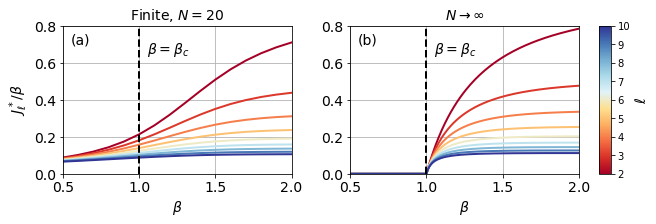

In [16]:
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom", sunset)

N = 20 #Size of the system

# Load data
df_finite = pd.read_csv(f"../Data/Jl_N{N}_diffbeta.txt", delim_whitespace=True)
df_infinite = pd.read_csv("../Data/Jl_Ninf_diffbeta.txt", delim_whitespace=True)

# ℓ values
unique_ells = sorted(df_finite["ℓ"].unique())
norm = mcolors.Normalize(vmin=min(unique_ells), vmax=max(unique_ells))
sm = cm.ScalarMappable(cmap=custom_cmap, norm=norm)

# Create figure with GridSpec and constrained layout
fig = plt.figure(figsize=(9, 3), constrained_layout=True)
gs = fig.add_gridspec(1, 4, width_ratios=[1, 0.000001, 1, 0.05])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[2])
cax = fig.add_subplot(gs[3])  # Colorbar axis

# Plot for finite N
for ell in unique_ells:
    group = df_finite[df_finite["ℓ"] == ell]
    color = custom_cmap(norm(ell))
    ax1.plot(group["β"], group["J_ℓ/β"], color=color, lw=2)

ax1.set_title("Finite, $N=20$", fontsize = 14)
ax1.set_xlabel(r"$\beta$", fontsize = 14)
ax1.set_ylabel(r"$J^*_\ell / \beta$", fontsize = 14)
ax1.axvline(x=1, color='black', linestyle='--', lw=2)
ax1.text(1.05, 0.65, r'$\beta = \beta_c$', fontsize=14)
ax1.text(0.55, 0.70, r'(a)', fontsize=14)
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlim(0.5, 2)
ax1.set_ylim(0, 0.8)

# Plot for N → ∞
for ell in unique_ells:
    group = df_infinite[df_infinite["ℓ"] == ell]
    if not group.empty:
        color = custom_cmap(norm(ell))
        ax2.plot(group["β"], group["J_ℓ/β"], color=color, lw=2)

ax2.set_title(r"$N \rightarrow \infty$", fontsize = 14)
ax2.set_xlabel(r"$\beta$", fontsize = 14)
ax2.axvline(x=1, color='black', linestyle='--', lw=2)
ax2.text(0.55, 0.70, r'(b)', fontsize=14)
ax2.text(1.05, 0.65, r'$\beta = \beta_c$', fontsize=14)
ax2.grid(True)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xlim(0.5, 2)
ax2.set_ylim(0, 0.8)

# Colorbar
cbar = fig.colorbar(sm, cax=cax, ticks=unique_ells)
cbar.set_label(r"$\ell$", fontsize = 14)

plt.savefig("../Plots/Jl_N20_diffbeta.pdf")

plt.show()


# Comparison Exact-Small $J_\ell$

In [ ]:
Nvalues = np.array([100, 500])
beta = 1

Wexact = []
Wexp = []

for N in Nvalues:
    Wexact.append(np.concatenate([np.array([0]),np.loadtxt(f"couplings_N{N}_beta{beta}.txt")]))
    Wexp.append(np.concatenate([np.array([0]),np.loadtxt(f"couplings_expansion_N{N}_beta{beta}.txt")[:,1]]))

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = ["teal", "firebrick"]

# First plot: Wexact and Wexp
for n in range(len(Nvalues)):
    axes[0].plot(Wexact[n], label=f'Exact {Nvalues[n]}', linestyle='-', color=colors[n])
    axes[0].plot(Wexp[n], label=f'Exp {Nvalues[n]}', linestyle='--', color=colors[n])

axes[0].set_title("Wexact vs Wexp")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Values")
axes[0].legend()
axes[0].grid(True)

# Second plot: Difference (Error)
for n in range(len(Nvalues)):
    axes[1].plot([a - b for a, b in zip(Wexact[n], Wexp[n])], label=f'Diff {Nvalues[n]}', linestyle='-', color=colors[n])

axes[1].set_title("Difference: Wexact - Wexp")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Error")
axes[1].legend()
axes[1].grid(True)

# Third plot: Relative Error
for n in range(len(Nvalues)):
    axes[2].plot([(a - b) / a for a, b in zip(Wexact[n], Wexp[n])], label=f'Relative {Nvalues[n]}', linestyle='-', color=colors[n])

axes[2].set_title("Relative Error: (J_exact - J_exp) / J_exact")
axes[2].set_xlabel("Index")
axes[2].set_ylabel("Relative Error")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Plot of the gradients

In [ ]:
def gradients_computer(N, dataset, optimal, epsilon=0.1, num_points=20):
    """
    Computes gradients of the loss with respect to structured weight perturbations
    in a lower-triangular matrix model. For each row i, it perturbs the shared value
    used in the allowed (i.e., j <= i) positions, computes the model's loss gradient
    with respect to that value, and returns a dictionary of (offset, gradient) pairs.

    Args:
        dataset (torch.Tensor): Input data.
        optimal (torch.Tensor): Optimal shared values per row in the weight matrix.
        epsilon (float): Range of the offset.
        num_points (int): Number of offset values to evaluate per row.

    Returns:
        dict: {row_index: [(offset, gradient), ...]} for each row.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = made(N)  # assume your MADE model definition is available
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0)  # dummy optimizer
    criterion = nn.BCELoss(reduction="sum")

    gradients = {}
    num_rows, num_cols = N, N  # assumes square weight matrix

    for i in range(num_rows):
        gradients[i] = []
        allowed_mask = torch.arange(num_cols, device=device) < i
        optimal_J_i = optimal[i]

        offsets = torch.linspace(-epsilon, epsilon, steps=num_points, device=device)

        for offset in offsets:
            candidate_value = optimal_J_i + offset

            # Create new weight matrix and set tied values
            new_weight = torch.zeros_like(model.layer.weight)
            new_weight[i, allowed_mask] = candidate_value
            new_weight = new_weight.clone().detach().requires_grad_(True)

            # Override model weights
            model.layer.weight = nn.Parameter(new_weight)

            # Compute gradient of loss
            optimizer.zero_grad()
            output = model(dataset)
            loss = criterion(output, (dataset + 1) / 2) / len(dataset)
            loss.backward()

            # Accumulate gradient from tied entries
            grad_i = model.layer.weight.grad[i, allowed_mask].sum().item() if i != 0 else 0
            gradients[i].append((offset.item(), grad_i))

    return gradients

We simulate a population of configurations to compute the averages

In [35]:
#parameters of the simulation
N = 20
beta = 1
pop_size = 5000000
num_sweeps = 30

#load the exact couplings
W = np.concatenate([np.array([0]),np.loadtxt(f"../Data/couplings_exact/couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
W *= beta

pop = montecarlo_CW(N, beta, pop_size, num_sweeps)

Then, we compute the gradients and compare the ones obtained from data with the ones found by linearizing

In [48]:
gradients = gradients_computer(N, pop, W, epsilon = 0.04, num_points=40)

Angular coefficient for key 1: 0.9555778184428751
Angular coefficient for key 7: 11.692630529304902
Angular coefficient for key 11: 24.08169056485672
Angular coefficient for key 14: 36.192174797914504
Angular coefficient for key 19: 61.80100848839608


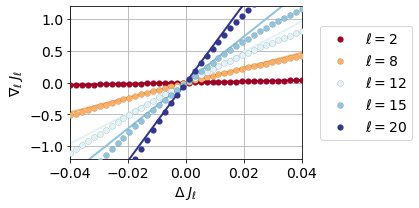

In [75]:
import matplotlib.pyplot as plt
import numpy as np

fontsize = 14

plt.figure(figsize=(6, 3))

# Set colormap to 'suset' and normalization range
cmap = mcolors.LinearSegmentedColormap.from_list("custom", sunset)
norm = plt.Normalize(vmin=1, vmax=19)

# Load Hessian data
hessian = np.loadtxt(f"../Data/hessian_N{N}_beta{beta}.txt")

# Plot for selected keys
for key in [1, 7, 11,14, 19]:
    gradient_values = gradients[key]
    candidate_values = np.array([item[0] for item in gradient_values])
    gradient_magnitudes = np.array([item[1] for item in gradient_values])
    
    # Compute and display the angular coefficient via linear fit
    coeffs = np.polyfit(candidate_values, gradient_magnitudes, 1)
    print(f'Angular coefficient for key {key}: {coeffs[0]}')
    
    # Pre-calculate x-values for the line
    x_vals = np.linspace(-0.04, 0.04, 10)
    plt.plot(x_vals, x_vals * hessian[key-1, 1] ,
             color=cmap(norm(key)), lw = 2)
    plt.scatter(candidate_values, gradient_magnitudes,
                color=cmap(norm(key)), edgecolor='black', linewidth=0.1, label=rf"$\ell = {key+1}$", zorder = 3)

plt.xlabel(r'$\Delta \; J_\ell$', fontsize=fontsize)
plt.ylabel(r'$\nabla_\ell \; J_\ell$', fontsize=fontsize)
plt.xlim(-0.04, 0.04)
plt.ylim(-1.2, 1.2)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize, bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.grid(True)
plt.tight_layout()
plt.savefig("../Plots/gradients_N20.pdf")
plt.show()


# Test of the linearization

In [6]:
# creates a MADE model starting from a given weight matrix

def setup_model(W, N = 100):
    model = made(N)
    weights = model.layer.weight.detach()

    # Update each row i of the weight matrix with W[i]
    for i in range(weights.shape[0]):
        weights[i, :] = W[i]

    # Set the upper triangular part of the matrix to 0
    weights = np.tril(weights, -1)  # Keep only the lower triangular part

    # Set the updated weights back to the model
    model.layer.weight.data = torch.tensor(weights)
    model = model.cuda()
    return model

In [7]:
#function to perform GD and saving the weights at certain epochs

def train_different_epochs(dataset, input_size, optimal, epochs_save, start = "optimal", pert_type = "uniform_small", epochs=1, optimizer = "SGD", batch_size=256, learning_rate = 0.001):
    """
    Train the MADE architecture using data.

    Parameters:
    - data: Training data as a PyTorch tensor, aka #configurations x #spins tensor.
    - input_size (int): Size of the input features.
    - epochs (int): Number of training epochs.
    - batch_size (int): Batch size for training.
    - learning_rate (float): Learning rate for optimization.

    Returns:
    - model: Trained MADE model.
    """
    data = torch.clone(dataset)
    model = made(input_size)
    model = model.to(device)
    # Set model.layer.weights to optimal, then add a small Gaussian perturbation
    with torch.no_grad():
        if start == "optimal":
            model.layer.weight = nn.Parameter(optimal.clone())
        elif start == "random":
            pass # layers are already initialized randomly 
        elif start == "zero":
            model.layer.weight = nn.Parameter(torch.zeros_like(model.layer.weight))
        else:
            raise ValueError(f"pert_type '{pert_type}' is not supported. Supported types are 'optimal' and 'random'")
        if pert_type == "uniform_small":
            perturbation = 0.01
        elif pert_type == "uniform_large":
            perturbation = 0.3
        elif pert_type == "none":
            perturbation = 0
        else:
            raise ValueError(f"pert_type '{pert_type}' is not supported. Supported types are 'uniform_small', 'uniform_large' and 'none'")
        model.layer.weight += perturbation
    model.train()
    clipper = AutoregressiveMasking()
    model.apply(clipper)

    weights = []

    if optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Optimizer '{optimizer}' is not supported. Supported optimizers are 'SGD' and 'Adam'")
    criterion = nn.BCELoss(reduction="mean")
    for epoch in tqdm(range(epochs)):
        tot_loss = 0
        count = 0
        if epoch in epochs_save:
            with torch.no_grad():
                res = model.layer.weight.sum(1)
                res[1:]/= torch.arange(1, len(res), device = "cuda")
                weights.append(res.cpu().numpy())
        for i in range(0, len(data), batch_size):
            indices = random.sample(range(data.shape[0]), batch_size)
            #batch_data = data[indices]
            batch_data = data[indices].to(device)

            # Forward pass
            output = model(batch_data)

            # Compute loss
            loss = criterion(output, (batch_data + 1) / 2)
            tot_loss += loss
            count += 1

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.apply(clipper)
    
    return model, weights

In [59]:
N = 200
beta = 1

#choose wheter to load the data or to perform the simulation. Warning: the simulation takes a lot of time
LOAD_DATA = True

if LOAD_DATA:
    weights = np.loadtxt(f"../Data/weights_N{N}_beta{beta}.txt")
else:
    #parameters of the simulation
    pop_size = 5000000
    num_sweeps = 30

    #load the exact couplings
    W = np.concatenate([np.array([0]),np.loadtxt(f"../Data/couplings_exact/couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
    W *= beta
    model_exact = setup_model(W, N = N)

    pop = montecarlo_CW(N, beta, pop_size, num_sweeps)

    num_epochs = 1501
    lr = 1
    save_epochs = np.arange(0, 1501, 5)
    model, weights  = train_different_epochs(pop, N, model_exact.layer.weight, save_epochs, start = "zero", pert_type="none", epochs = num_epochs, learning_rate=lr, batch_size=len(pop))
    weights = np.array(weights)

In [57]:
backup_weights = np.copy(weights)

In [58]:
np.savetxt(f"../Data/weights_N{N}_beta{beta}.txt", weights)

In [31]:
# Expression of the behaviour of the J(t) i the linearized regime
def Jt_app(t, c, ell, tau, eta):
    return c*tau*(ell-1)*(1-np.exp(-eta*t/tau))

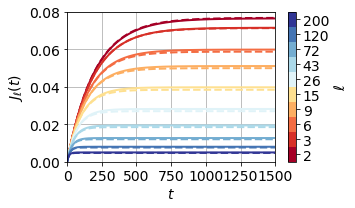

In [62]:
# Aesthetics
fontsize = 14
plt.figure(figsize=(5, 3))

# Example function
c = 0.0768534
#c = 0.210102

def tau_l(c, ell):
    return 1 / (1 + c * (ell - 2))/(ell-1)

# Logarithmically spaced ell values
ell_values = np.unique(np.round(np.geomspace(2, 200, num=10)).astype(int))

# Plotting loop using indexed colors
for idx, ell in enumerate(ell_values):
    color = sunset[idx]
    
    plt.plot(
        save_epochs,
        weights[:, ell - 1],
        lw=2,
        ls='-',
        color=color
    )
    plt.plot(
        save_epochs,
        Jt_app(save_epochs, c, ell, tau_l(c, ell), 1/N/(ell-1)),
        lw=2,
        ls='--',
        color=color
    )

# Labels and formatting
plt.ylabel(r"$J_\ell(t)$", fontsize=fontsize)
plt.xlabel(r"$t$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlim(save_epochs[0], save_epochs[-1])
plt.ylim(0, 0.08)
plt.grid(True)
plt.tight_layout()

# Discrete colorbar setup
cmap = mpl.colors.ListedColormap(sunset)
bounds = np.arange(len(ell_values) + 1) - 0.5
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ticks=np.arange(len(ell_values)))
cbar.ax.set_yticklabels(ell_values)  # Map ticks to ell values
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'$\ell$', fontsize=fontsize)
plt.tight_layout()
plt.savefig("../Plots/weights_vs_epochs.pdf")
plt.show()
